# X-ray diffraction analysis
The aim of the project is to create a code able to import and plot data coming from an X-ray diffraction (XRD) experiment, detect and list the characteristic peaks, while avoiding those coming from $K_\beta$ transitions since already counted in $K_\alpha$ peaks, and finally match each peak to its own phase.
A second task is to make the code as much general as possible (regardless of type of the source file and the complexity of the experimental pattern), accurate in results and simple for the user. To this end, the code consists of a single function (you can find the final code at the end of the notebook and in a separate file called Project.ipynb) whose inputs are directly asked to the user by the interface. Among such inputs, two of them allow the user to tune two paramenters so that he can manually adjust the peaks recognition step and make it more accurate.
Although the function is a single one, the notebook presenting the work is divided in sections to guide the reader through the steps that lead to the final result. Such steps are reported after importing the necessary python libraries and specifically they are:

i. Import experimental data

ii. Removal of the background

iii. Plotting

iv. Peaks recognition

v. Peaks matching

In [ ]:
pip install pymatgen 

In [ ]:
#if it does not work you can use Google Colab to install pymatgen

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.core.structure import Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from itertools import zip_longest
import csv

## Import experimental data 
Since the most common output files of the softwares paired with x-ray diffractometers are '.txt' and '.csv', the code is designed in order to be able to import the angle-intensity pairs from these two types of file. These pairs are then converted into arrays so that they can be processed as sets of numbers.
Let's consider for instance the experimental data of an x-ray diffraction pattern of a CuAg powder:

In [6]:
filename = 'CuAg_meas.txt'
if filename[-3:] == 'txt':
        with open(filename, 'r') as file:
            lines = file.readlines()
            x = []
            y = []
            for line in lines:
                try:
                    values = line.strip().split()
                    x.append(float(values[0]))
                    y.append(float(values[1]))
                except ValueError:
                    pass 

            angle = np.array(x) 
elif filename[-3:] == 'csv':
            with open(filename, 'r') as file_csv:
                csv_reader = csv.reader(file_csv)
                x = []
                y = []
                for row in csv_reader:
                        try:
                            x.append(float(row[0].replace(',', '.')))                            
                            y.append(float(row[1].replace(',', '.')))
                        except ValueError:
                            pass
                angle = np.array(x) 

intensity_noBG = np.array(y)

angle_label = np.array(["Angle [°]:"])
angletoprint = np.concatenate((angle_label,angle[0:20]))
intensity_label = np.array(["Intensity [a.u.]:"])
inttoprint = np.concatenate((intensity_label,intensity_noBG[0:20]))
max_length = max(len(angletoprint), len(inttoprint)) 
for ang, inten in zip_longest(angletoprint, inttoprint, fillvalue=""): 
     ang_str = str(ang)
     int_str = str(inten)
     print(f"{ang_str:<15s} {int_str}")

Angle [°]:      Intensity [a.u.]:
20.0            10850.0
20.01           10600.0
20.02           10860.0
20.03           10800.0
20.04           10620.0
20.05           10740.0
20.06           10830.0
20.07           10930.0
20.08           11000.0
20.09           10750.0
20.1            10660.0
20.11           10810.0
20.12           10740.0
20.13           10780.0
20.14           10680.0
20.15           10900.0
20.16           10780.0
20.17           10760.0
20.18           10860.0
20.19           10830.0


## Removal of the background
Optionally, an additional file can be provided to remove the background from the experimental spectrum and make the plot more readable. Being an optional function, in case no file is provided, an array composed of zeros with the same shape of the array containing the intensity values will be used as default.

In [3]:
background = 'CuAg_back.txt'

if background is None or background.lower() == 'none' or not background.strip():
    background = np.zeros(intensity_noBG.shape)
else:
    with open(background, 'r') as file:
        lines = file.readlines()

        data_lines = lines[2:]
        x1 = []
        y1 = []
        for line in data_lines:
            values = line.strip().split()
            x1.append(float(values[0]))
            y1.append(float(values[1]))

        background = np.array(y1)

intensity = np.subtract(intensity_noBG, background)

## Plotting
In order to show visually how the removal of the background improves the readability of the spectrum, it is worth to produce a plot for the two cases: the original spectrum and the one obtained after removing the background.
The code segment related to plotting is capable of generating a line graph of the XRD pattern. It will plot the XRD pattern for the two cases mentioned above. Additionally, labels for the axes, a title and a legend are included in the plot. The code also provides an interactive interface to optionally set the limits for the x-axis.

Enter the x limit as x_start x_finish:20 100


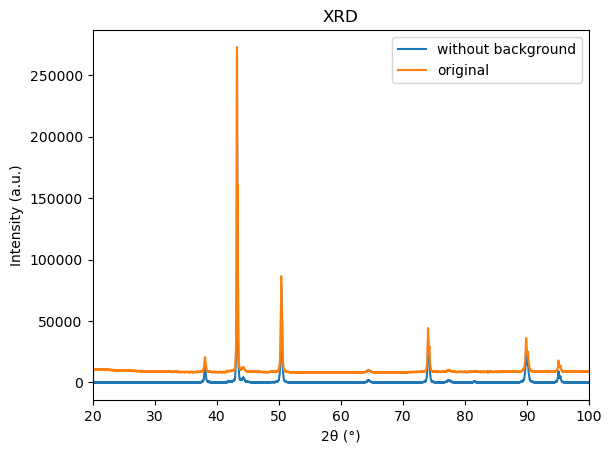

In [4]:
x_limit = (input("Enter the x limit as x_start x_finish:"))
if x_limit is not None:
        x_limit = [float(x) for x in x_limit.split()]
        plt.xlim(x_limit)
plt.plot(angle, intensity, label='without background')
plt.plot(angle, intensity_noBG, label='original')
plt.ylabel('Intensity (a.u.)')
plt.xlabel('2θ (°)')
plt.title('XRD')
plt.legend()
plt.show()


## Peaks recognition
Although the 'find_peaks' function is available in numpy library, it does not allow to filter out the peaks related to $K_\beta$ transitions. Thus a different code is made to fulfill this task. Such code considers the intensity value of each index in the 'intensity' array and compares it with the neighbouring ones in a range proportional to the 'spacing' value provided as input. Since spacing is an optional input of the function and its default value depends on the shape of the 'angle' array, it is defined after the latter. The 'i' index is picked as belonging to a peak if it corresponds to the maximum intensity in the range and has a sufficiently large difference (depending on the 'min_diff' value) with the minimum value in the range. The angles associated to indexes considered as peaks are saved in the "peaksang" array while their intensity values are listed in "peaksint".
The plotting section of the code is then implemented so that the recognised peaks are marked with a star with the aim of visually checking if the code worked correctly. Finally, peaks angles and intensities are listed.

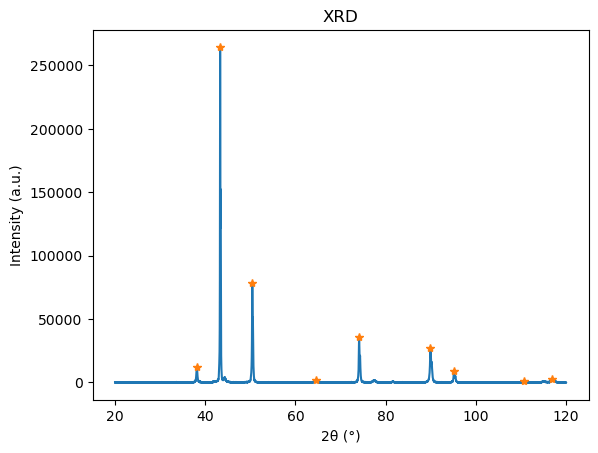

Angle [°]:      Intensity [a.u.]:
38.12           12059.0
43.3            264566.0
50.43           78066.0
64.49           2027.0
74.12           35821.0
89.95           27320.0
95.15           9245.0
110.71          782.0
116.95          2797.0


In [5]:
spacing = None
min_diff = 1
spacing = int(spacing) if spacing else None
min_diff = float(min_diff) if min_diff else 1
if spacing is None:
    spacing = int((angle.shape[0])/25)
peaksang = []
peaksint = []
for i in list(range(len(angle))): 
        if i-spacing < 0:
             if intensity[i] == max(intensity[0:i+spacing+1]) and intensity[i] > min_diff*abs((min(intensity[0:i+spacing+1])+1000)): # abs because after removing the background there might be negative values; +1 because if 0 there is no effect
                peaksang = peaksang + [angle[i]]
                peaksint = peaksint + [intensity[i]]
        elif i+spacing>len(angle):
            if intensity[i] == max(intensity[i-spacing:]) and intensity[i] > min_diff*abs((min(intensity[i-spacing:])+1000)):
               peaksang = peaksang + [angle[i]]
               peaksint = peaksint + [intensity[i]]
        else:
            if intensity[i] == max(intensity[i-spacing:i+spacing]) and intensity[i] > min_diff*abs((min(intensity[i-spacing:i+spacing])+1000)):
                peaksang = peaksang + [angle[i]]
                peaksint = peaksint + [intensity[i]]
                
plt.plot(angle, intensity)
plt.plot(peaksang, peaksint, "*")
plt.ylabel('Intensity (a.u.)')
plt.xlabel('2θ (°)')
plt.title('XRD')
plt.show()

angle_label = np.array(["Angle [°]:"])
angletoprint = np.concatenate((angle_label,peaksang))
intensity_label = np.array(["Intensity [a.u.]:"])
inttoprint = np.concatenate((intensity_label,peaksint))
max_length = max(len(angletoprint), len(inttoprint)) 
for ang, inten in zip_longest(angletoprint, inttoprint, fillvalue=""): 
    ang_str = str(ang)
    int_str = str(inten)
    print(f"{ang_str:<15s} {int_str}")

The plot and the list of angle-intensity pairs shown above prove that the code is working well on the XRD spectrum of the Cu-Ag powder after removing the background.
Can the code be equally able to recognise peaks even for a more complex spectrum and additionally without removing the background?
In order to prove it we report here also the XRD spectrum of a thin film of Cu$_3$BiS$_3$ deposited on fluorine-doped tin oxide, whose data are contained in a 'csv' file this time:

In [ ]:
filename = 'SDS_2e5mM_FAST.csv'
if filename[-3:] == 'txt':
        with open(filename, 'r') as file:
            lines = file.readlines()
            x = []
            y = []
            for line in lines:
                try:
                  values = line.strip().split()
                  x.append(float(values[0]))
                  y.append(float(values[1]))
                except ValueError:
                  pass 

            angle = np.array(x) 
elif filename[-3:] == 'csv':
            with open(filename, 'r') as file_csv:
                csv_reader = csv.reader(file_csv)
                x = []
                y = []
                for row in csv_reader:
                        try:
                            x.append(float(row[0].replace(',', '.')))                            
                            y.append(float(row[1].replace(',', '.')))
                        except ValueError:
                            pass
                angle = np.array(x) 
if spacing is None:
    spacing = int((angle.shape[0])/25)

intensity_noBG = np.array(y)

background=None
if background is None or background.lower() == 'none' or not background.strip():
    background = np.zeros(intensity_noBG.shape)
else:
    with open(background, 'r') as file:
        lines = file.readlines()

        data_lines = lines[2:]
        x1 = []
        y1 = []
        for line in data_lines:
            values = line.strip().split()
            x1.append(float(values[0]))
            y1.append(float(values[1]))

        background = np.array(y1)

intensity = np.subtract(intensity_noBG, background)

spacing = None
min_diff = 1
if spacing is None:
    spacing = int((angle.shape[0])/25)
peaksang = []
peaksint = []
for i in list(range(len(angle))): 
        if i-spacing < 0:
             if intensity[i] == max(intensity[0:i+spacing+1]) and intensity[i] > min_diff*abs((min(intensity[0:i+spacing+1])+1000)): # abs because after removing the background there might be negative values; +1 because if 0 there is no effect
                peaksang = peaksang + [angle[i]]
                peaksint = peaksint + [intensity[i]]
        elif i+spacing>len(angle):
            if intensity[i] == max(intensity[i-spacing:]) and intensity[i] > min_diff*abs((min(intensity[i-spacing:])+1000)):
               peaksang = peaksang + [angle[i]]
               peaksint = peaksint + [intensity[i]]
        else:
            if intensity[i] == max(intensity[i-spacing:i+spacing]) and intensity[i] > min_diff*abs((min(intensity[i-spacing:i+spacing])+1000)):
                peaksang = peaksang + [angle[i]]
                peaksint = peaksint + [intensity[i]]
                
plt.plot(angle, intensity)
plt.plot(peaksang, peaksint, "*")
plt.ylabel('Intensity (a.u.)')
plt.xlabel('2θ (°)')
plt.title('XRD')
plt.show()

angle_label = np.array(["Angle [°]:"])
angletoprint = np.concatenate((angle_label,peaksang))
intensity_label = np.array(["Intensity [a.u.]:"])
inttoprint = np.concatenate((intensity_label,peaksint))
max_length = max(len(angletoprint), len(inttoprint)) 
for ang, inten in zip_longest(angletoprint, inttoprint, fillvalue=""): 
    ang_str = str(ang)
    int_str = str(inten)
    print(f"{ang_str:<15s} {int_str}")

We see that, by using the default values, the code is not detecting all the peaks present in the spectrum but, since we have the chance to adjust the result, we may succeed in getting all the peaks recognised by manually changing the values of spacing and min_diff.
The plot below shows graphically the result after considering 'spacing = 25' and 'min_diff = 0.1':

In [ ]:
spacing = 25
min_diff = 0.1
peaksang = []
peaksint = []
for i in list(range(len(angle))): 
    if i-spacing < 0:
        if intensity[i] == max(intensity[0:i+spacing+1]) and intensity[i] > min_diff*abs((min(intensity[0:i+spacing+1])+1000)): # abs because after removing the background there might be negative values; +1 because if 0 there is no effect
            peaksang = peaksang + [angle[i]]
            peaksint = peaksint + [intensity[i]]
    elif i+spacing>len(angle):
        if intensity[i] == max(intensity[i-spacing:]) and intensity[i] > min_diff*abs((min(intensity[i-spacing:])+1000)):
            peaksang = peaksang + [angle[i]]
            peaksint = peaksint + [intensity[i]]
    else:
        if intensity[i] == max(intensity[i-spacing:i+spacing]) and intensity[i] > min_diff*abs((min(intensity[i-spacing:i+spacing])+1000)):
            peaksang = peaksang + [angle[i]]
            peaksint = peaksint + [intensity[i]]

# PLOTTING
plt.plot(angle,intensity)
plt.plot(peaksang, peaksint, "*")
plt.ylabel('Intensity (a.u.)')
plt.xlabel('2θ (°)')
plt.title('XRD')
plt.show()

And you can see that after a simple tuning of the two input variables all the peaks are now recognised.

## Peaks matching
The code begins by checking the CIF files provided by the user for the different phases. It is designed to handle up to three phases, but the code can be easily modified to accommodate more phases if needed. If there are fewer than three phases, the user can input 'None' for the references that are not present.

Then, if a reference file is provided, it initializes an XRDCalculator object, it reads the crystal structure from the reference CIF file and calculate the XRD pattern for that crystal structure.

For each phase, the code iterates over each peak angle (stored in peaksang) and checks if there is a matching peak in the XRD pattern. If a match is found, the peak angle and its corresponding intensity (stored in peaksint) are added to the respective match list.

Data points corresponding to the matched peaks are added to the plot. The interactive interface allows to set the names of the phases that the user wants to display in the legend of the plot. 

Lastly, there is the possibility to save the plot with a user-defined name provided through the interactive interface.

Please note that the pymatgen library needs to be installed before running this code, as it provides the necessary modules for crystal structure handling and XRD pattern calculations.

In [ ]:
    reference1='Cu3BiS3.cif'
    name1 = 'Cu3BiS3' 
    # reference1
    if reference1 is not None and reference1[-3:] == 'cif':
      xrd_calculator=XRDCalculator()
      structure1 = Structure.from_file(reference1)
      phase1 = xrd_calculator.get_pattern(structure1, two_theta_range=(angle[0], angle[-1])) #you can change the range if needed
      match1 = []
      remaining1 = []
      for a1 in peaksang:
          found_match = False
          for a2 in phase1.x:
              if a2 is not None and a2 - 1.5 <= a1 <= a2 + 1.5:
                  match1.append(a1)
                  found_match = True
                  break
              if not found_match:
                 remaining1.append(a1)
      phase1_int = [peaksint[peaksang.index(angle)] for angle in match1]
      plt.plot(match1,phase1_int, "o", label = name1)

    # reference2
    reference2='SnO2.cif'
    name2 = 'SnO2' 
    if reference2 is not None and reference2[-3:] == 'cif':
      xrd_calculator=XRDCalculator()
      structure2 = Structure.from_file(reference2)
      phase2 = xrd_calculator.get_pattern(structure2, two_theta_range=(angle[0], angle[-1])) #you can change the range if needed
      match2 = []
      remaining2 = []
      for a1 in peaksang:
          found_match = False
          for a2 in phase2.x:
              if a2 is not None and a2 - 1.5 <= a1 <= a2 + 1.5:
                  match2.append(a1)
                  found_match = True
                  break
              if not found_match:
                 remaining2.append(a1)
      phase2_int = [peaksint[peaksang.index(angle)] for angle in match2]
      plt.plot(match2,phase2_int, "o", label = name2)

    # reference3
    reference3= None
    name3 = None 
    if reference3 is not None and reference3[-3:] == 'cif':
      xrd_calculator=XRDCalculator()
      structure3 = Structure.from_file(reference3)
      phase3 = xrd_calculator.get_pattern(structure3, two_theta_range=(angle[0], angle[-1])) #you can change the range if needed
      match3 = []
      remaining3 = []
      for a1 in peaksang:
          found_match = False
          for a2 in phase3.x:
              if a2 is not None and a2 - 1.5 <= a1 <= a2 + 1.5:
                  match3.append(a1)
                  found_match = True
                  break
              if not found_match:
                 remaining3.append(a1)
      phase3_int = [peaksint[peaksang.index(angle)] for angle in match3]
      plt.plot(match3,phase3_int, "o", label = name3)
        
    plt.plot(angle,intensity)
    plt.plot(peaksang, peaksint, "*")
    plt.ylabel('Intensity (a.u.)')
    plt.xlabel('2θ (°)')
    plt.title('XRD')
    plt.legend()
    plt.show()
    plt.savefig(input("Enter the name of the plot: "))

## CODE
The code is collected in a single function and it is reported below. The interactive interface will guide the user throught the selection of the input files and customizable variables (e.g., spacing, min_diff and x_limit).

Enter the name of the measurements file: CuAg_meas.txt
Enter the spacing (or press Enter for default): 25
Enter the minimum difference (or press Enter for default): 1
Enter the name of the background file (or press enter for no background): CuAg_back.txt
Enter the name of the CIF file of phase1: Cu.cif
Enter the name of phase1: Cu
Enter the name of the CIF file of phase2 (or type 'None'): Ag.cif
Enter the name of phase2(or type 'None'): Ag
Enter the name of the CIF file of phase3(or type 'None'): None
Enter the name of phase3(or type 'None'): None
Enter the x limit as x_start x_finish:20 100


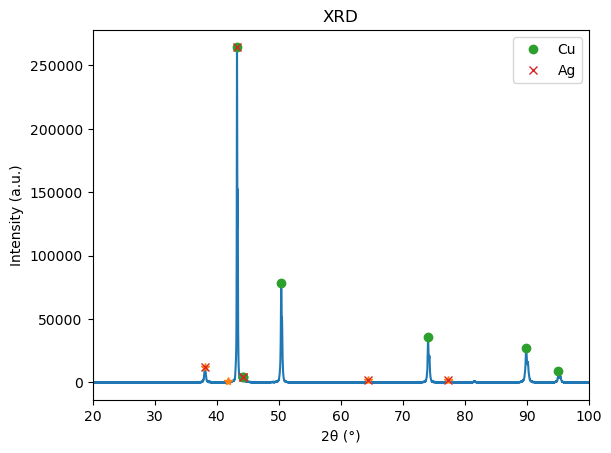

Enter the name of the plot: CuAg_XRD
Angle [°]:      Intensity [a.u.]:
38.12           12059.0
41.8            1011.0
43.3            264566.0
44.26           4063.0
44.34           4063.0
50.43           78066.0
64.49           2027.0
74.12           35821.0
77.39           1876.0
89.95           27320.0
95.15           9245.0
116.95          2797.0


<Figure size 640x480 with 0 Axes>

In [7]:
def xrdpeaks(filename, spacing= None, min_diff=1, background=None, reference1=None, name1=None, reference2=None, name2=None, reference3=None, name3=None, x_limit=None):
    # whenCalling this function you need to define two outputs (e.g. out1, out2 = xrdpeaks(...))
    # while the arguments of the function must be, in order, the name of the file containing XRD data,
    # an integer number defining how spaced (in terms of array index) two peaks must be distant (at least) to be defined as such
    # another number to define the minimum height for a peak (with respect to the neighbouring minimum) to be difined as such
    # in case the 1st number is omitted it would be considered a 25th of the number of indexes of angle
    # in case the 2nd number is omitted it would be considered equal to 2.5
    # the fourth (optional) input is the name of the file containing the background data
    if filename[-3:] == 'txt':
        with open(filename, 'r') as file:
            lines = file.readlines()
            x = []
            y = []
            for line in lines:
                try:
                  values = line.strip().split()
                  x.append(float(values[0]))
                  y.append(float(values[1]))
                except ValueError:
                    pass 

            angle = np.array(x) 
    elif filename[-3:] == 'csv':
        with open(filename, 'r') as file_csv:
            csv_reader = csv.reader(file_csv)
            x = []
            y = []
            for row in csv_reader:
                    try:
                        x.append(float(row[0].replace(',', '.')))                            
                        y.append(float(row[1].replace(',', '.')))
                    except ValueError:
                        pass
                    angle = np.array(x) 

                
    if spacing is None:
        spacing = int((angle.shape[0])/25)

    intensity_noBG = np.array(y)

    # REMOVAL OF THE BACKGROUND
    if background is None or background.lower() == 'none' or not background.strip():
        background = np.zeros(intensity_noBG.shape)
    else:
        with open(background, 'r') as file:
            lines = file.readlines()

            data_lines = lines[2:]
            x1 = []
            y1 = []
            for line in data_lines:
                values = line.strip().split()
                x1.append(float(values[0]))
                y1.append(float(values[1]))

            background = np.array(y1)

    intensity = np.subtract(intensity_noBG, background)



    # SEEK AND COLLECTION OF PEAKS
    peaksang = []
    peaksint = []
    for i in list(range(len(angle))): #the for loop varies across the indexes (NOT values) of the array 'angle'
        if i-spacing < 0:
             if intensity[i] == max(intensity[0:i+spacing+1]) and intensity[i] > min_diff*abs((min(intensity[0:i+spacing+1])+1000)): # abs because after removing the background there might be negative values; +1 because if 0 there is no effect
                peaksang = peaksang + [angle[i]]
                peaksint = peaksint + [intensity[i]]
        elif i+spacing>len(angle):
            if intensity[i] == max(intensity[i-spacing:]) and intensity[i] > min_diff*abs((min(intensity[i-spacing:])+1000)):
               peaksang = peaksang + [angle[i]]
               peaksint = peaksint + [intensity[i]]
        else:
            if intensity[i] == max(intensity[i-spacing:i+spacing]) and intensity[i] > min_diff*abs((min(intensity[i-spacing:i+spacing])+1000)):
                peaksang = peaksang + [angle[i]]
                peaksint = peaksint + [intensity[i]]

    # PLOTTING
    plt.plot(angle,intensity)
    plt.plot(peaksang, peaksint, "*")
    plt.ylabel('Intensity (a.u.)')
    plt.xlabel('2θ (°)')
    plt.title('XRD')
    if x_limit is not None:
        x_limit = [float(x) for x in x_limit.split()]
        plt.xlim(x_limit)

    # MATCHING
    # reference1
    if reference1 is not None and reference1[-3:] == 'cif':
      xrd_calculator=XRDCalculator()
      structure1 = Structure.from_file(reference1)
      phase1 = xrd_calculator.get_pattern(structure1, two_theta_range=(angle[0], angle[-1])) #you can change the range if needed
      match1 = []
      remaining1 = []
      for a1 in peaksang:
          found_match = False
          for a2 in phase1.x:
              if a2 is not None and a2 - 1.5 <= a1 <= a2 + 1.5:
                  match1.append(a1)
                  found_match = True
                  break
              if not found_match:
                 remaining1.append(a1)
      phase1_int = [peaksint[peaksang.index(angle)] for angle in match1]
      plt.plot(match1,phase1_int, "o", label = name1)

    # reference2
    if reference2 is not None and reference2[-3:] == 'cif':
      xrd_calculator=XRDCalculator()
      structure2 = Structure.from_file(reference2)
      phase2 = xrd_calculator.get_pattern(structure2, two_theta_range=(angle[0], angle[-1])) #you can change the range if needed
      match2 = []
      remaining2 = []
      for a1 in peaksang:
          found_match = False
          for a2 in phase2.x:
              if a2 is not None and a2 - 1.5 <= a1 <= a2 + 1.5:
                  match2.append(a1)
                  found_match = True
                  break
              if not found_match:
                 remaining2.append(a1)
      phase2_int = [peaksint[peaksang.index(angle)] for angle in match2]
      plt.plot(match2,phase2_int, "x", label = name2)

    # reference3
    if reference3 is not None and reference3[-3:] == 'cif':
      xrd_calculator=XRDCalculator()
      structure3 = Structure.from_file(reference3)
      phase3 = xrd_calculator.get_pattern(structure3, two_theta_range=(angle[0], angle[-1])) #you can change the range if needed
      match3 = []
      remaining3 = []
      for a1 in peaksang:
          found_match = False
          for a2 in phase3.x:
              if a2 is not None and a2 - 1.5 <= a1 <= a2 + 1.5:
                  match3.append(a1)
                  found_match = True
                  break
              if not found_match:
                 remaining3.append(a1)
      phase3_int = [peaksint[peaksang.index(angle)] for angle in match3]
      plt.plot(match3,phase3_int, "o", label = name3)

    plt.legend()
    plt.show()
    plt.savefig(input("Enter the name of the plot: "))

    # PRINTING
    angle_label = np.array(["Angle [°]:"])
    angletoprint = np.concatenate((angle_label,peaksang))
    intensity_label = np.array(["Intensity [a.u.]:"])
    inttoprint = np.concatenate((intensity_label,peaksint))
    max_length = max(len(angletoprint), len(inttoprint)) #determines the maximum size of the elements to print

    for ang, inten in zip_longest(angletoprint, inttoprint, fillvalue=""): #this for loop allows to print the pairs of values in two different columns
        ang_str = str(ang)
        int_str = str(inten)
        print(f"{ang_str:<15s} {int_str}")

    return peaksang, peaksint

# Calling the function and defining inputs

filename = input("Enter the name of the measurements file: ")
spacing = input("Enter the spacing (or press Enter for default): ")
min_diff = input("Enter the minimum difference (or press Enter for default): ")
background = input("Enter the name of the background file (or press enter for no background): ")
reference1= input("Enter the name of the CIF file of phase1: ")
name1= input("Enter the name of phase1: ")
reference2= input("Enter the name of the CIF file of phase2 (or type 'None'): ")
name2= input("Enter the name of phase2(or type 'None'): ")
reference3= input("Enter the name of the CIF file of phase3(or type 'None'): ")
name3= input("Enter the name of phase3(or type 'None'): ")
x_limit= (input("Enter the x limit as x_start x_finish:"))

spacing = int(spacing) if spacing else None
min_diff = float(min_diff) if min_diff else 1


peaksang, peaksint = xrdpeaks(filename, spacing, min_diff, background, reference1, name1, reference2, name2, reference3, name3, x_limit)

